# JAK2 Min Analysis

In [1]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


## Imports

In [2]:
import os
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from irelease.utils import generate_smiles, canonical_smiles
import nb_utils as nbu
from math import ceil
from sklearn.manifold import TSNE
import pandas as pd
import rdkit.Chem as Chem
from rdkit.Chem.Draw import DrawingOptions
from rdkit.Chem import Draw

RDKit WARNING: [13:35:46] Enabling RDKit 2019.09.3 jupyter extensions


mol_metrics: reading NP model ...
loaded in 0.459716796875
mol_metrics: reading SA model ...
loaded in 1.8048875331878662


In [3]:
DrawingOptions.atomLabelFontSize = 50
DrawingOptions.dotsPerAngstrom = 100
DrawingOptions.bondLineWidth = 3

## Load SMILES files

In [4]:
ppo_grl_train = 'jak2_min/JAK2_min_IReLeaSE-PPO_with_irl.json'
ppo_grl_eval = 'jak2_min/JAK2_min_smiles_biased_ppo_grl_eval.json'
ppo_baseline_reward_train = 'jak2_min/JAK2_min_IReLeaSE-PPO__baseline_reward.json'
ppo_baseline_reward_eval = 'jak2_min/JAK2_min_smiles_biased_ppo_baseline_reward_eval.json'
reinforce_train = 'jak2_min/JAK2_min_IReLeaSE-REINFORCE_no_irl.json'
reinforce_eval = 'jak2_min/JAK2_min_smiles_biased_reinforce_eval.json'
reinforce_grl_train = 'jak2_min/JAK2_min_IReLeaSE-REINFORCE_with_irl.json'
reinforce_grl_eval = 'jak2_min/JAK2_min_smiles_biased_reinforce_grl_eval.json'

In [5]:
ppo_grl_smiles_valid,  ppo_grl_smiles_invalid = nbu.smiles_from_json_data(ppo_grl_eval)
ppo_grl_conv = nbu.get_convergence_data(ppo_grl_train)
ppo_baseline_reward_smiles_valid, ppo_baseline_reward_smiles_invalid = nbu.smiles_from_json_data(ppo_baseline_reward_eval)
ppo_baseline_reward_conv = nbu.get_convergence_data(ppo_baseline_reward_train)
reinforce_smiles_valid, reinforce_smiles_invalid = nbu.smiles_from_json_data(reinforce_eval)
reinforce_conv = nbu.get_convergence_data(reinforce_train)
reinforce_grl_smiles_valid, reinforce_grl_smiles_invalid = nbu.smiles_from_json_data(reinforce_grl_eval)
reinforce_grl_conv = nbu.get_convergence_data(reinforce_grl_train)
len(ppo_grl_smiles_valid), len(ppo_baseline_reward_smiles_valid), len(reinforce_smiles_valid), len(reinforce_grl_smiles_valid)

(3448, 1534, 7698, 6964)

In [6]:
# CSV files containing predictions/evaluations
preds_ppo_grl_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_ppo_grl_eval.csv')
preds_ppo_baseline_reward_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_ppo_baseline_reward_eval.csv')
preds_reinforce_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_reinforce_eval.csv')
preds_reinforce_grl_eval = pd.read_csv('jak2_min/JAK2_min_smiles_biased_reinforce_grl_eval.csv')
preds_demo = pd.read_csv('jak2_min/jak2_min_biased.csv')
preds_unbiased = pd.read_csv('jak2_min/jak2_unbiased.csv')
preds_ppo_grl_eval.shape, preds_ppo_baseline_reward_eval.shape, preds_reinforce_eval.shape, preds_reinforce_grl_eval.shape, preds_demo.shape, preds_unbiased.shape

((3448, 2), (1534, 2), (7698, 2), (6964, 2), (10000, 2), (10000, 2))

In [7]:
preds_ppo_grl_eval.shape[0] / 10000. * 100., preds_ppo_baseline_reward_eval.shape[0] / 10000. * 100., preds_reinforce_eval.shape[0] / 10000. * 100., preds_reinforce_grl_eval.shape[0] / 10000. * 100., preds_demo.shape[0] / 10000. * 100., preds_unbiased.shape[0] / 10000. * 100.

(34.48, 15.340000000000002, 76.98, 69.64, 100.0, 100.0)

## Evaluate SMILES

In [8]:
generators = nbu.data_provider('../../data/jak2_min_smiles_biased.smi', '../../data/unbiased_smiles.smi')

In [37]:
demo_smiles = generators['demo_data'].random_training_set_smiles(10000)
demo_smiles = list(set(demo_smiles))
unbiased_smiles = generators['unbiased_data'].random_training_set_smiles(10000)
unbiased_smiles = list(set(unbiased_smiles))

In [38]:
demo_smiles[0], unbiased_smiles[0], len(demo_smiles)

('CC(=O)c1ccccc1', 'CN(Cc1ccc2c(c1)OCCO2)Cc1cccs1', 310)

In [11]:
preds_ppo_grl_smiles = preds_ppo_grl_eval['prediction'].tolist()
preds_ppo_baseline_reward_smiles = preds_ppo_baseline_reward_eval['prediction'].tolist()
preds_reinforce_smiles = preds_reinforce_eval['prediction'].tolist()
preds_reinforce_grl_smiles = preds_reinforce_grl_eval['prediction'].tolist()
preds_demo_smiles = preds_demo['prediction'].tolist()
preds_unbiased_smiles = preds_unbiased['prediction'].tolist()

## KDE plots

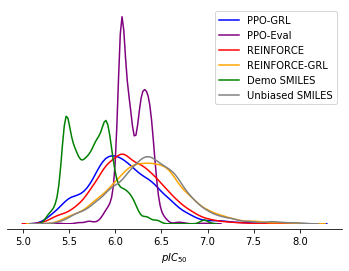

In [12]:
sns.kdeplot(preds_ppo_grl_smiles, label='PPO-GRL', shade=False, color='blue')
sns.kdeplot(preds_ppo_baseline_reward_smiles, label='PPO-Eval', shade=False, color='purple')
sns.kdeplot(preds_reinforce_smiles, label='REINFORCE', shade=False, color='red')
ax = sns.kdeplot(preds_reinforce_grl_smiles, label='REINFORCE-GRL', shade=False, color='orange')
sns.kdeplot(preds_demo_smiles, label='Demo SMILES', shade=False, color='green')
ax = sns.kdeplot(preds_unbiased_smiles, label='Unbiased SMILES', shade=False, color='gray')
plt.xlabel('$pIC_{50}$')
# ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# ax.set_xticks([])
sns.despine(offset=5, left=True, bottom=False)
plt.savefig('jak2_min/jak2_min_kde_plots.pdf')
plt.show()

## Convergence plot

In [13]:
ppo_grl_biased = ppo_grl_conv['biased']
ppo_baseline_reward_biased = ppo_baseline_reward_conv['biased']
reinforce_biased = reinforce_conv['biased']
reinforce_grl_biased = reinforce_grl_conv['biased']
demo_vals = reinforce_grl_conv['demo']
unbiased_vals = reinforce_grl_conv['baseline']

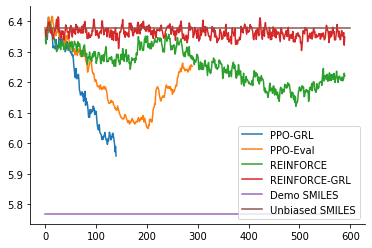

In [14]:
offset = 10
plt.plot(nbu.smoothing_values(ppo_grl_biased, 0.6)[offset:150])
plt.plot(nbu.smoothing_values(ppo_baseline_reward_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_biased, 0.6)[offset:])
plt.plot(nbu.smoothing_values(reinforce_grl_biased, 0.6)[offset:])
plt.plot(demo_vals)
plt.plot(unbiased_vals)
plt.legend(['PPO-GRL','PPO-Eval','REINFORCE','REINFORCE-GRL', 'Demo SMILES', 'Unbiased SMILES'], loc='lower right')
plt.savefig('jak2_min/jak2_min_irl_vs_rl_convergence.pdf')
sns.despine()

## t-SNE plot

In [15]:
hparams = {'d_model': 1500,
            'dropout': 0.0,
            'monte_carlo_N': 5,
            'use_monte_carlo_sim': True,
            'no_mc_fill_val': 0.0,
            'gamma': 0.97,
            'episodes_to_train': 10,
            'gae_lambda': 0.95,
            'ppo_eps': 0.2,
            'ppo_batch': 1,
            'ppo_epochs': 5,
            'entropy_beta': 0.01,
            'bias_mode': 'max',
            'use_true_reward': False,
            'baseline_reward': False,
            'reward_params': {'num_layers': 2,
                              'd_model': 512,
                              'unit_type': 'gru',
                              'demo_batch_size': 32,
                              'irl_alg_num_iter': 5,
                              'dropout': 0.2,
                              'use_attention': False,
                              'use_validity_flag': True,
                              'bidirectional': True,
                              'optimizer': 'adadelta',
                              'optimizer__global__weight_decay': 0.0005,
                              'optimizer__global__lr': 0.001, },
            'agent_params': {'unit_type': 'gru',
                             'num_layers': 2,
                             'stack_width': 1500,
                             'stack_depth': 200,
                             'optimizer': 'adadelta',
                             'optimizer__global__weight_decay': 0.005,
                             'optimizer__global__lr': 0.001},
            'critic_params': {'num_layers': 2,
                              'd_model': 256,
                              'dropout': 0.2,
                              'unit_type': 'gru',
                              'optimizer': 'adam',
                              'optimizer__global__weight_decay': 0.005,
                              'optimizer__global__lr': 0.001},
            'expert_model_dir': './model_dir/expert_xgb_reg'
            }

In [16]:
init_dict = nbu.initialize(hparams, generators['demo_data'], generators['unbiased_data'], True)

In [17]:
# encoder = init_dict['encoder']
# ppo_reward_net_rnn = init_dict['reward_net_rnn']
# ppo_reward_net = init_dict['reward_net']
# ppo_reward_net.load_state_dict(nbu.load_model_weights('../model_dir/JAK2_max_irelease_stack-rnn_gru_ppo_reward_net_2020_07_12__20_54_23_1.003_66.mod'))

In [18]:
# with torch.set_grad_enabled(False):
#     reward_lst, logits_lst = [], []
#     tsne_smiles = ppo_grl_smiles_valid + ppo_grl_smiles_invalid
#     for i in range(0, len(tsne_smiles), 500):
#         inp, valid_vec = nbu.smiles_to_tensor(['<'+s+'>' for s in tsne_smiles[i:i+500]])
#         enc_out = encoder([inp, valid_vec])
#         reward, logits = ppo_reward_net_rnn(enc_out, return_logits=True)
#         reward_lst.append(reward)
#         logits_lst.append(logits)
#     reward = -torch.cat(reward_lst)
#     logits = torch.cat(logits_lst)

In [19]:
# logits.shape, reward.shape

In [20]:
# tsne_rep = TSNE(n_components=2).fit_transform(logits.detach().cpu().numpy())
# tsne_data = pd.DataFrame({'x':tsne_rep[:,0], 'y':tsne_rep[:,1]})
# tsne_rep.shape

In [21]:
# plt.figure(figsize=(10,10))
# points = plt.scatter(tsne_data['x'], tsne_data['y'], c=reward.detach().cpu().numpy().reshape(-1,), s=50, cmap="Spectral")
# cb = plt.colorbar(points, ticks=None)
# cb.outline.set_visible(False)
# ax = sns.scatterplot(x="x", y="y", hue=reward.detach().cpu().numpy().reshape(-1,), data=tsne_data, 
#                     legend=False, palette='Spectral', edgecolor='black', linewidth=.01)
# v = []
# # valid SMILES
# while True:
#     va_idx = np.random.randint(len(ppo_grl_smiles_valid))
#     comp = ppo_grl_smiles_valid[va_idx]
#     i = len(v)+1
#     if len(comp) <= 50:
#         v.append(comp)
#         ax.annotate('val-'+str(i), xy=(tsne_data['x'][va_idx], tsne_data['y'][va_idx]), 
#                     xytext=(-20+(i*10),50), 
#                     arrowprops=dict(facecolor='black', arrowstyle='-'),
#                    horizontalalignment='right', verticalalignment='top')
#         if len(v) == 3:
#             break

# inv = []
# # invalid SMILES
# for i in range(3):
#     inv_idx = np.random.randint(len(ppo_grl_smiles_invalid))
#     inv.append(ppo_grl_smiles_invalid[inv_idx])
#     ax.annotate('inv-'+str(i+1), xy=(tsne_data['x'][len(ppo_grl_smiles_valid) + inv_idx], 
#                     tsne_data['y'][len(ppo_grl_smiles_valid) + inv_idx]), 
#                 xytext=(-50+(i*10),40), arrowprops=dict(facecolor='black', arrowstyle='-'),
#                horizontalalignment='right', verticalalignment='top')

# print('selected valid:\n', v)
# print('selected invalid:\n', inv)
# plt.axis('off')
# plt.savefig('jak2_max/jak2_max_ppo_grl_tsne.pdf')
# plt.show()

##  Draw random SMILES

In [22]:
vis_mols = [Chem.MolFromSmiles(sm, sanitize=True) for sm in set(ppo_grl_smiles_valid) if len(sm)]# <= 50]
sanitized_gen_mols = [vis_mols[i] for i in np.where(np.array(vis_mols) != None)[0]]
len(sanitized_gen_mols)

3446

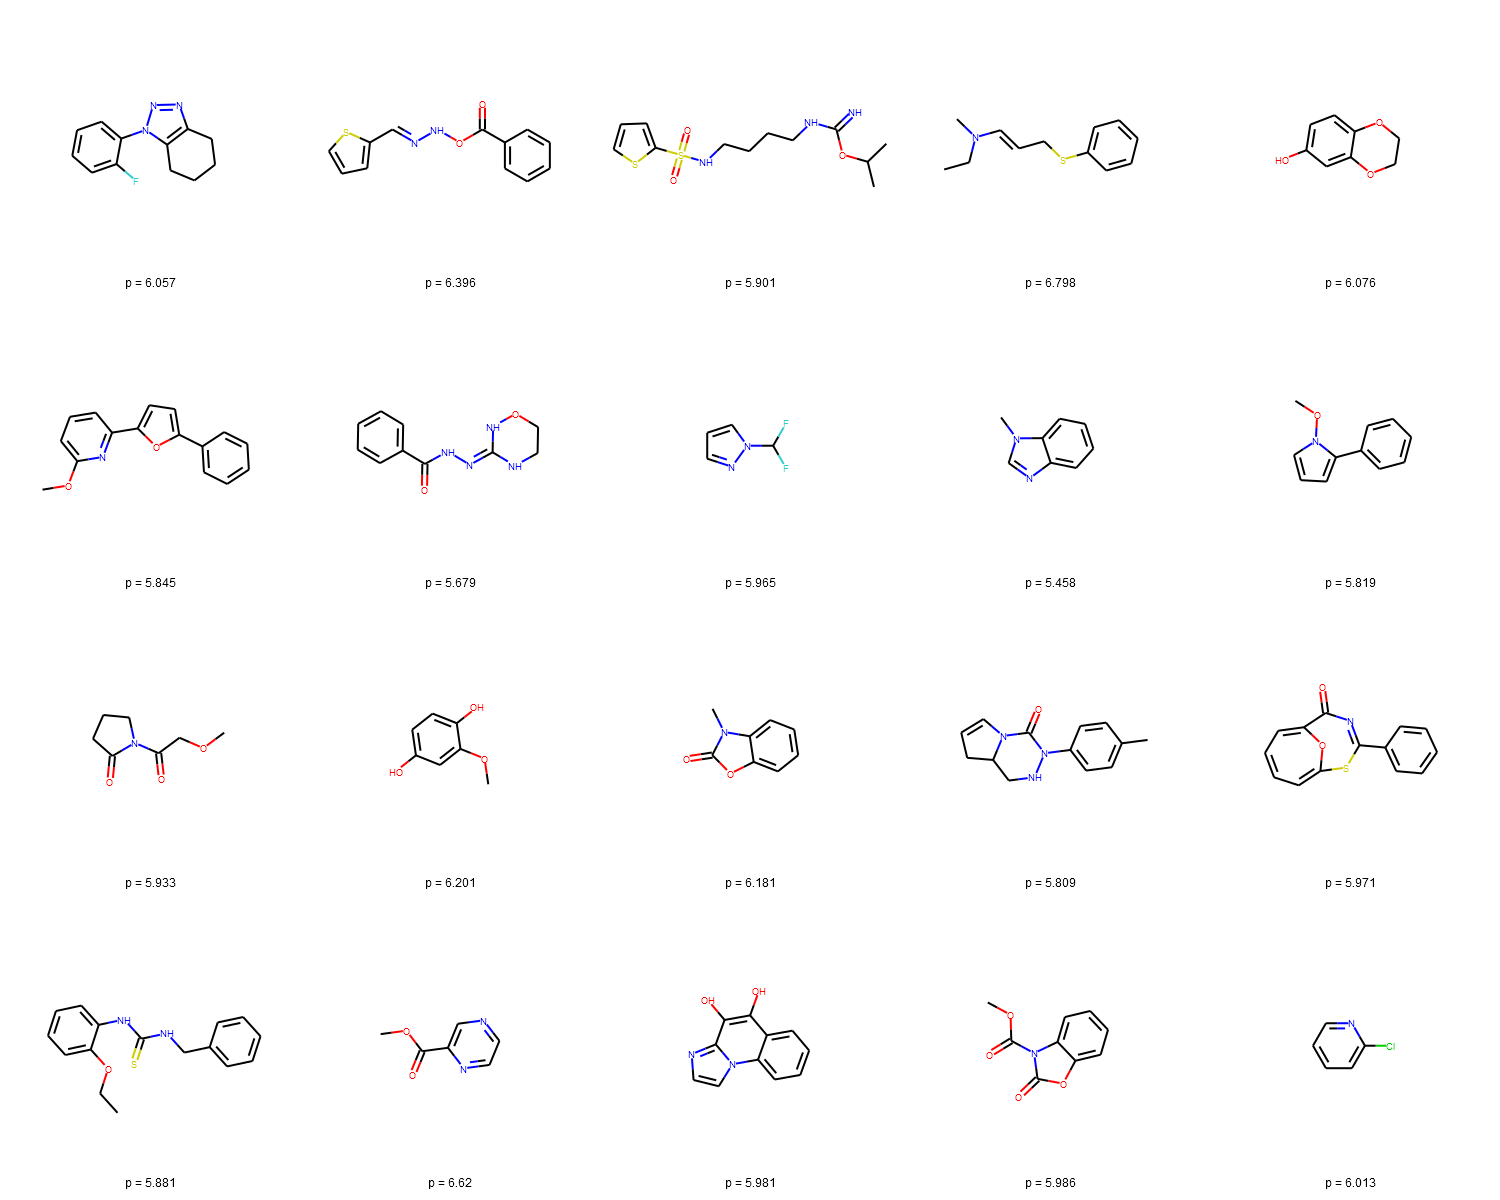

In [23]:
n_to_draw = 20
ind = np.random.randint(0, len(sanitized_gen_mols), n_to_draw)
mols_to_draw = [sanitized_gen_mols[i] for i in ind]
legends = ['p = ' + str(round(float(preds_ppo_grl_smiles[i]), 3)) for i in ind]
Draw.MolsToGridImage(mols_to_draw, molsPerRow=5, subImgSize=(300,300), legends=legends)

In [24]:
for i, mol in enumerate(mols_to_draw):
    print(f'{Chem.MolToSmiles(mol)}\t\t{legends[i]}')

Fc1ccccc1-n1nnc2c1CCCC2		p = 6.057
O=C(ONN=Cc1cccs1)c1ccccc1		p = 6.396
CC(C)OC(=N)NCCCCNS(=O)(=O)c1cccs1		p = 5.901
CCN(C)C=CCSc1ccccc1		p = 6.798
Oc1ccc2c(c1)OCCO2		p = 6.076
COc1cccc(-c2ccc(-c3ccccc3)o2)n1		p = 5.845
O=C(NN=C1NCCON1)c1ccccc1		p = 5.679
FC(F)n1cccn1		p = 5.965
Cn1cnc2ccccc21		p = 5.458
COn1cccc1-c1ccccc1		p = 5.819
COCC(=O)N1CCCC1=O		p = 5.933
COc1cc(O)ccc1O		p = 6.201
Cn1c(=O)oc2ccccc21		p = 6.181
Cc1ccc(N2NCC3CC=CN3C2=O)cc1		p = 5.809
O=C1N=C(c2ccccc2)SC2=CC=CC=C1O2		p = 5.971
CCOc1ccccc1NC(=S)NCc1ccccc1		p = 5.881
COC(=O)c1cnccn1		p = 6.62
Oc1c(O)c2nccn2c2ccccc12		p = 5.981
COC(=O)n1c(=O)oc2ccccc21		p = 5.986
Clc1ccccn1		p = 6.013


In [25]:
# Save selected compounds to file
# os.makedirs('./drd2_samples', exist_ok=True)
# for i, mol in enumerate(mols_to_draw):
#     Draw.MolToImageFile(mol, f'./drd2/sample_compound_{i+1}.png')

## Molecule metrics

In [39]:
def mol_metrics(df):
    results = {}
    num_can = 0
    for idx, df_smiles in enumerate([df, df[df['prediction'] <= np.mean(demo_vals)]]):
        new_smiles, valid_vec = canonical_smiles(df_smiles['SMILES'].tolist())
        smiles = []
        for i, s in enumerate(new_smiles):
            if valid_vec[i] == 1:
                smiles.append(s)
        smiles = set(smiles)
        eval_dict = nbu.evaluate(smiles, demo_smiles)
        eval_dict['Num of canonical SMILES'] = len(smiles)
        if idx==0:
            num_can = len(smiles)
        eval_dict['percentage of valid'] = df_smiles.shape[0] / 10000. * 100.
        if idx==1:            
            eval_dict['percentage in threshold (canonical)'] = len(smiles) / num_can
        results['no_threshold' if idx==0 else 'with_threshold'] = eval_dict
    return results

In [27]:
mol_metrics(preds_ppo_grl_eval)

{'no_threshold': {'novelty': 0.9764808362369338,
  'hard_novelty': 0.9764808362369338,
  'soft_novelty': 0.9835365853658538,
  'external_diversity': 0.24378342371166434,
  'internal_diversity': 0.906823009085585,
  'conciseness': 1.0,
  'solubility': 0.48825967384657487,
  'naturalness': 0.5063995767849119,
  'synthesizability': 0.7761091336750476,
  'druglikeliness': 0.6630972039104548,
  'Num of canonical SMILES': 3446,
  'percentage of valid': 34.48},
 'with_threshold': {'novelty': 0.9336219336219336,
  'hard_novelty': 0.9336219336219336,
  'soft_novelty': 0.9535353535353535,
  'external_diversity': 0.06096582819810975,
  'internal_diversity': 0.8797303973437831,
  'conciseness': 1.0,
  'solubility': 0.5342211989694822,
  'naturalness': 0.4534048251899461,
  'synthesizability': 0.8516653429738087,
  'druglikeliness': 0.6731554610684009,
  'Num of canonical SMILES': 693,
  'percentage of valid': 6.93,
  'percentage in threshold (canonical)': 0.20110272780034824}}

In [28]:
mol_metrics(preds_ppo_baseline_reward_eval)

{'no_threshold': {'novelty': 0.9993472584856397,
  'hard_novelty': 0.9993472584856397,
  'soft_novelty': 0.9995430809399477,
  'external_diversity': 0.007655116965819642,
  'internal_diversity': 0.7030861874962964,
  'conciseness': 1.0,
  'solubility': 0.9971499809844281,
  'naturalness': 0.7558490708351214,
  'synthesizability': 0.41398470455282155,
  'druglikeliness': 0.04859840459974036,
  'Num of canonical SMILES': 1533,
  'percentage of valid': 15.340000000000002},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.0,
  'internal_diversity': 0.6184407535690439,
  'conciseness': 1.0,
  'solubility': 1.0,
  'naturalness': 0.7279267567814998,
  'synthesizability': 0.3865760421652652,
  'druglikeliness': 0.04962474464790094,
  'Num of canonical SMILES': 10,
  'percentage of valid': 0.1,
  'percentage in threshold (canonical)': 0.006523157208088715}}

In [29]:
mol_metrics(preds_reinforce_eval)

{'no_threshold': {'novelty': 0.997270245677889,
  'hard_novelty': 0.997270245677889,
  'soft_novelty': 0.9980891719745224,
  'external_diversity': 0.2340283864699607,
  'internal_diversity': 0.9080170645702652,
  'conciseness': 1.0,
  'solubility': 0.6553258854320503,
  'naturalness': 0.5905267757792846,
  'synthesizability': 0.7989081309243576,
  'druglikeliness': 0.6492502557023753,
  'Num of canonical SMILES': 7694,
  'percentage of valid': 76.98},
 'with_threshold': {'novelty': 0.9925788497217068,
  'hard_novelty': 0.9925788497217068,
  'soft_novelty': 0.9948051948051949,
  'external_diversity': 0.08550362734648732,
  'internal_diversity': 0.8907705609500783,
  'conciseness': 1.0,
  'solubility': 0.6808227106215512,
  'naturalness': 0.4998975818812226,
  'synthesizability': 0.8869799164764105,
  'druglikeliness': 0.6766710202246418,
  'Num of canonical SMILES': 1078,
  'percentage of valid': 10.79,
  'percentage in threshold (canonical)': 0.1401091759812841}}

In [30]:
mol_metrics(preds_reinforce_grl_eval)

{'no_threshold': {'novelty': 0.998992950654582,
  'hard_novelty': 0.998992950654582,
  'soft_novelty': 0.9992950654582075,
  'external_diversity': 0.3759906435865974,
  'internal_diversity': 0.9169378048893023,
  'conciseness': 0.9999928067903898,
  'solubility': 0.6623483217464537,
  'naturalness': 0.5466234664445946,
  'synthesizability': 0.6570844935924802,
  'druglikeliness': 0.6125933823934495,
  'Num of canonical SMILES': 6953,
  'percentage of valid': 69.64},
 'with_threshold': {'novelty': 0.9979591836734694,
  'hard_novelty': 0.9979591836734694,
  'soft_novelty': 0.9985714285714286,
  'external_diversity': 0.14227033882510587,
  'internal_diversity': 0.896687655028338,
  'conciseness': 1.0,
  'solubility': 0.6815195714514837,
  'naturalness': 0.43228251981960925,
  'synthesizability': 0.8312231022466787,
  'druglikeliness': 0.6711269144105704,
  'Num of canonical SMILES': 490,
  'percentage of valid': 4.9,
  'percentage in threshold (canonical)': 0.07047317704587948}}

In [31]:
mol_metrics(preds_demo)

{'no_threshold': {'novelty': 0.07601387985252657,
  'hard_novelty': 0.07601387985252657,
  'soft_novelty': 0.3532097158967685,
  'external_diversity': 0.039815522470483325,
  'internal_diversity': 0.8278000383996401,
  'conciseness': 1.0,
  'solubility': 0.5341709069120854,
  'naturalness': 0.5484759339068722,
  'synthesizability': 0.8953266592019845,
  'druglikeliness': 0.6043368768092581,
  'Num of canonical SMILES': 9222,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 0.0847457627118644,
  'hard_novelty': 0.0847457627118644,
  'soft_novelty': 0.359322033898305,
  'external_diversity': 0.0015972264751634184,
  'internal_diversity': 0.784799033621093,
  'conciseness': 1.0,
  'solubility': 0.5385727966911444,
  'naturalness': 0.505524238774605,
  'synthesizability': 0.9078483819305384,
  'druglikeliness': 0.6165359505985967,
  'Num of canonical SMILES': 4779,
  'percentage of valid': 51.22,
  'percentage in threshold (canonical)': 0.5182173064411191}}

In [32]:
mol_metrics(preds_unbiased)

{'no_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.3792674219122904,
  'internal_diversity': 0.9172093645408316,
  'conciseness': 1.0,
  'solubility': 0.6537168149513535,
  'naturalness': 0.554249677373528,
  'synthesizability': 0.6410245249259279,
  'druglikeliness': 0.6037894919031428,
  'Num of canonical SMILES': 10000,
  'percentage of valid': 100.0},
 'with_threshold': {'novelty': 1.0,
  'hard_novelty': 1.0,
  'soft_novelty': 1.0,
  'external_diversity': 0.07518724675554216,
  'internal_diversity': 0.8865583338581228,
  'conciseness': 1.0,
  'solubility': 0.6798339657803556,
  'naturalness': 0.42225967290564004,
  'synthesizability': 0.8272307161879014,
  'druglikeliness': 0.655259223585056,
  'Num of canonical SMILES': 617,
  'percentage of valid': 6.17,
  'percentage in threshold (canonical)': 0.0617}}

## RNN hidden neurons examination

In [33]:
# def plot_heatmap(smiles_list, logits, neuron=None, save=False):
#     if neuron is None:
#         neuron = np.random.randint(logits.shape[-1])
#     print(f'Plotting for neuron {neuron}')
#     for i, smiles in enumerate(smiles_list):
#         arr = logits[:len(smiles), i, neuron].reshape(1, len(smiles))
#         chars = np.array([c for c in smiles]).reshape(1,-1)
#         fig = plt.figure(figsize=(200,4))
#         sns.heatmap(arr, annot=chars, fmt='', cbar=False, 
#                     cmap=sns.color_palette("bwr", 10), annot_kws={'size':100, 'fontweight':'normal'},
#                    xticklabels=False, yticklabels=False, square=True)
#         if save:
#             os.makedirs(f'drd2/neuron_{neuron}', exist_ok=True)
#             plt.savefig(f'drd2/neuron_{neuron}/{i}.png')
#         plt.show()

In [34]:
# plot_heatmap(ppo_samples[:10], ppo_samples_neurons[:,:10,:])